In [1]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import remove_fitted_sources

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Local Paths (NB Inputs)

In [5]:
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas_abell370_f105w_v1.0-epoch2_drz.fits"
input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz.fits"
#input_data_path = "https://archive.stsci.edu/pub/hlsp/frontier/abell370/images/hst/v1.0-epoch2/hlsp_frontier_hst_acs-30mas-selfcal_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
#input_data_path = "/Users/rgeda/project/data/lcbg/hlsp_frontier_hst_acs-30mas_abell370/hlsp_frontier_hst_acs-30mas_abell370-hffpar_f435w_v1.0-epoch2_drz.fits"
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

print("Output: ", output_path)

Output:  hlsp_frontier_hst_wfc3-30mas-bkgdcor_abell370_f105w_v1.0-epoch2_drz_catalog.csv


# Load Data

In [6]:
hdul = fits.open(input_data_path)
hdu = hdul[0]

In [7]:
data = hdu.data
header = hdu.header
wcs = WCS(header)

In [8]:
#plt.imshow(data, vmin=0, vmax=2.9534784e-05*90)

# Estimate Mean Noise

0.000312165

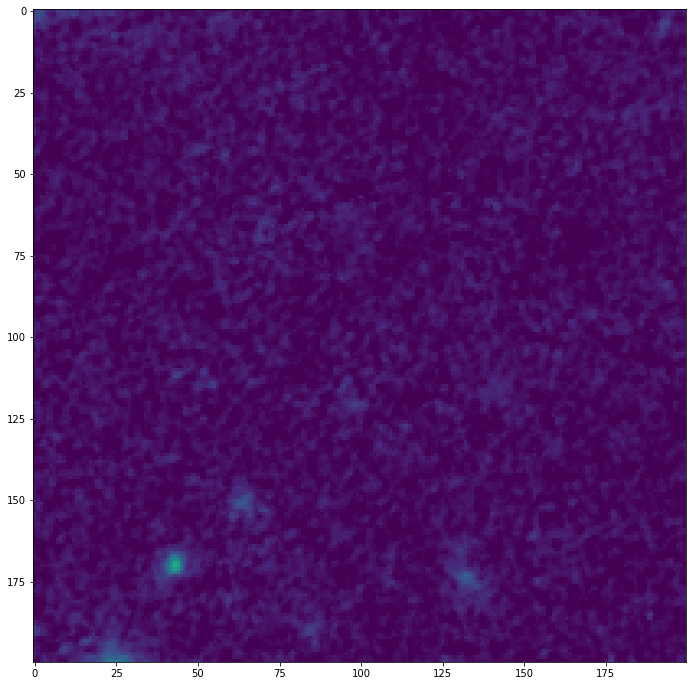

In [9]:
subsection = cutout(data, 4444, 10150, 200)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)
subsection.mean()

In [10]:
mean_noise = subsection.mean()
mean_noise

0.000312165

# Aperture Photometry

### Select Image

In [11]:
cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
image = cutout(data, cx, cy, 4000)

In [12]:
image_wcs = wcs.copy()

delta_pix = np.array([cx, cy]) - np.array(image.shape)//2

image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix

In [13]:
# sigma_clip = SigmaClip(sigma=3.)
# bkg_estimator = MedianBackground()
# bkg = Background2D(image, (50, 50), filter_size=(3, 3), 
#                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

# image = image - bkg.background

image -= mean_noise

In [14]:
image = np.clip(image, 0, image.max())

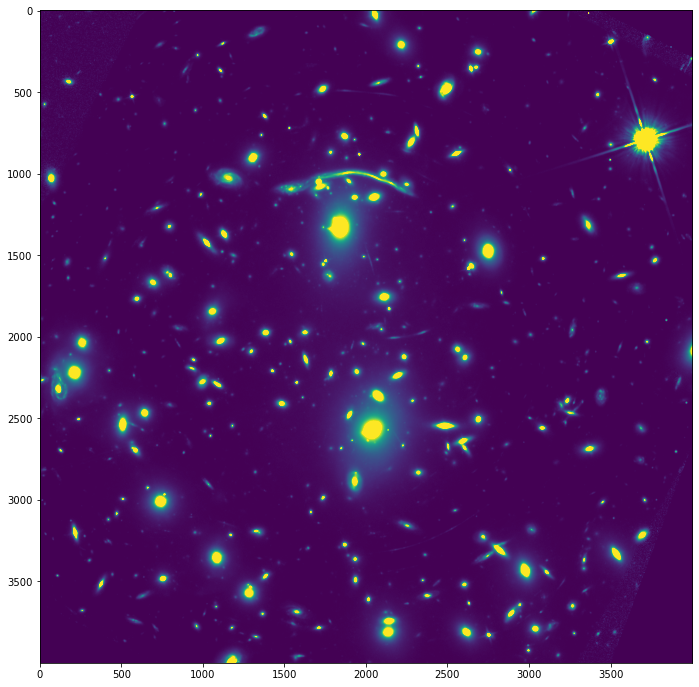

In [15]:
plt.imshow(image, vmin=0, vmax=mean_noise*300)

### Make Segments

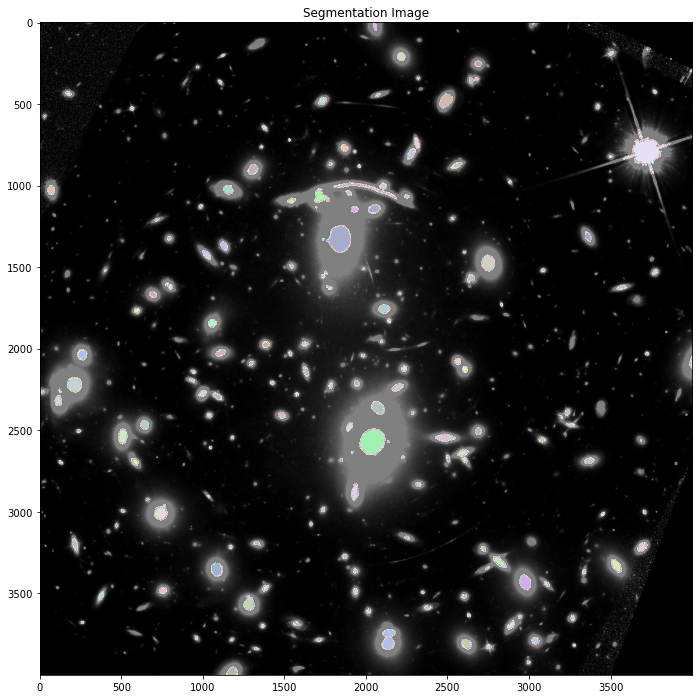

In [16]:
nsigma = np.zeros_like(image) + image.mean()*5
segm = make_segments(image, nsigma=nsigma, kernel_size=None)
plot_segments(segm, image, vmin=0, vmax=mean_noise*50)

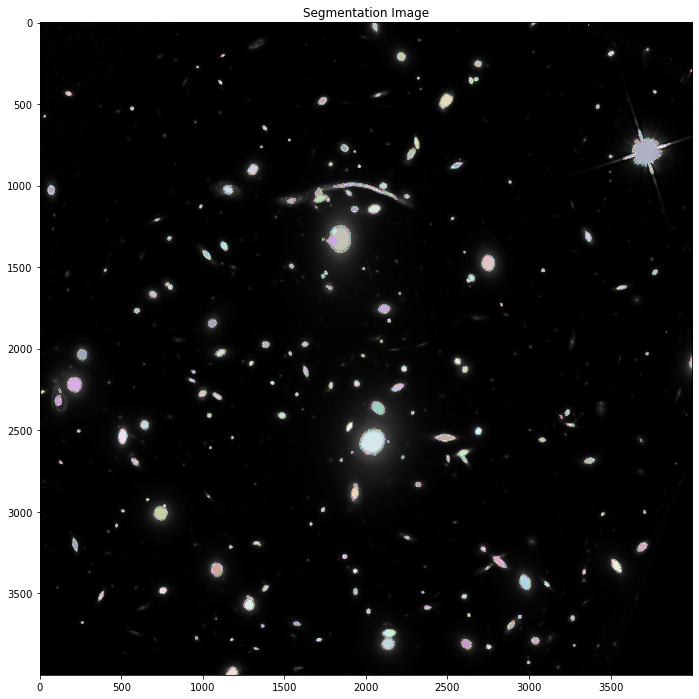

In [17]:
segm_deblend = deblend_segments(image, segm)
plot_segments(segm_deblend, image, vmin=0, vmax=mean_noise*300)

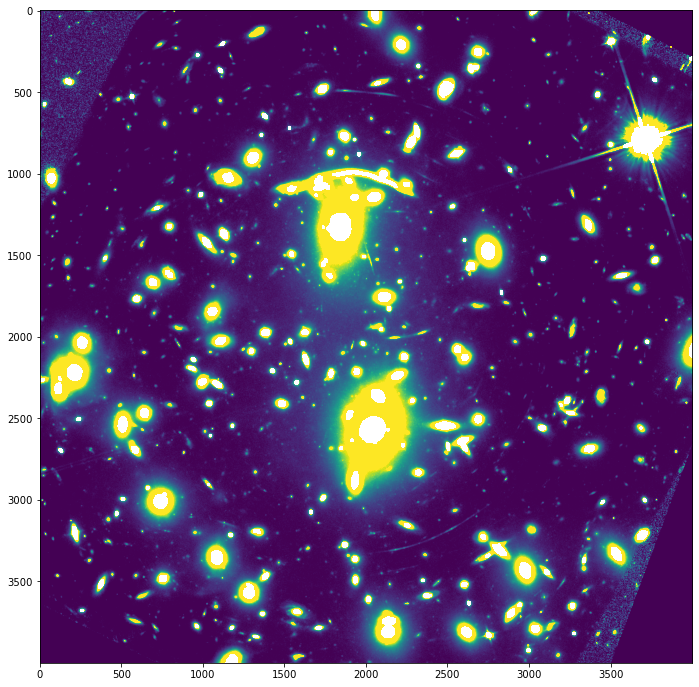

In [18]:
image_residual = image.copy()
image_residual[np.where(segm.data != 0)] = np.nan
plt.imshow(image_residual, vmin=0, vmax=mean_noise*50)
#plot_segment_residual(segm_deblend, image)

In [19]:
segm_deblend.remove_border_labels(50)
len(segm_deblend.segments)

191

### Make Catalog

In [20]:
cat = source_properties(image, segm_deblend, wcs=image_wcs)

# Fitted Photometry

IntProgress(value=0, description='Loading:', max=2)

1 177


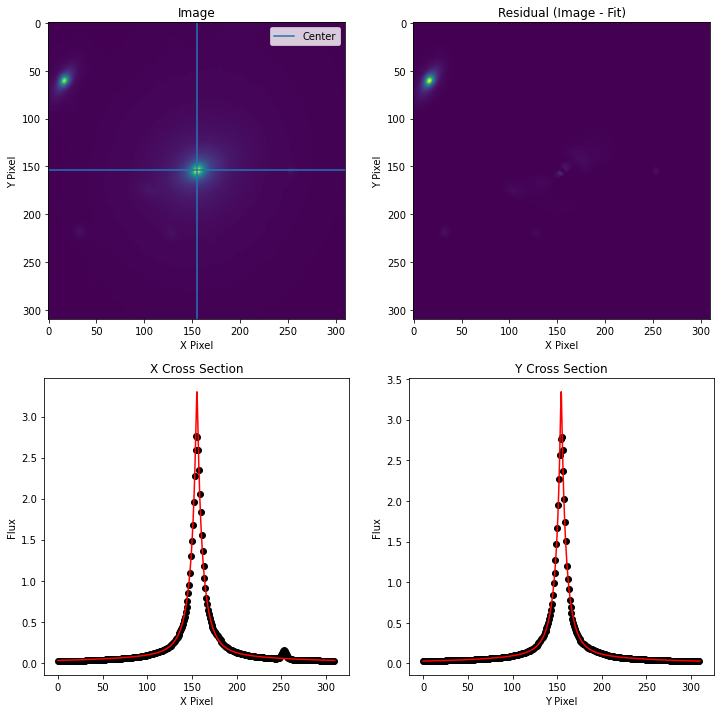

2 171


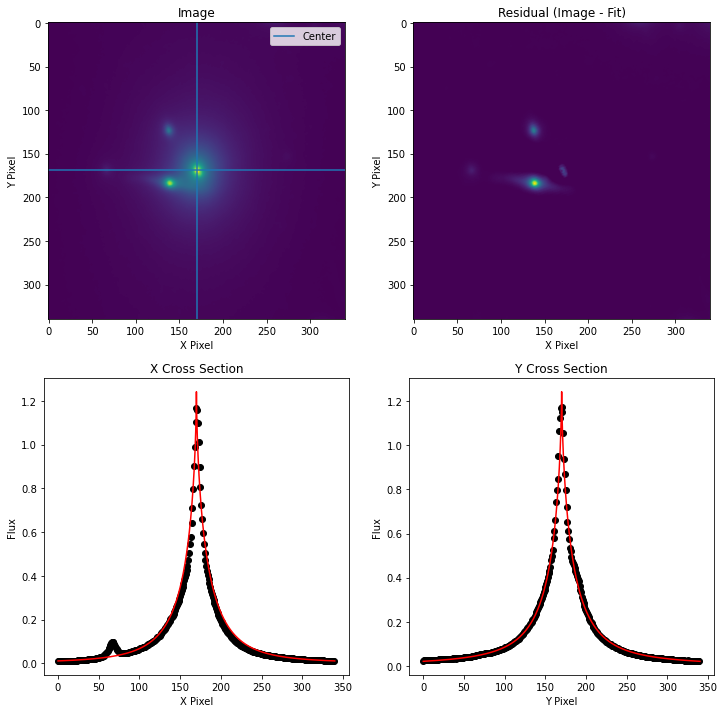

In [23]:
image_copy_0, image_residual_copy_0, image_zero_0, photometric_sums_0 = remove_fitted_sources(
    image, image_residual, cat, show_progress=True,
    r_inner_mult=1, r_outter_mult=10, index_start=1, 
    index_end=3, show_fit=True, n_models=2, r_output_mult=25)

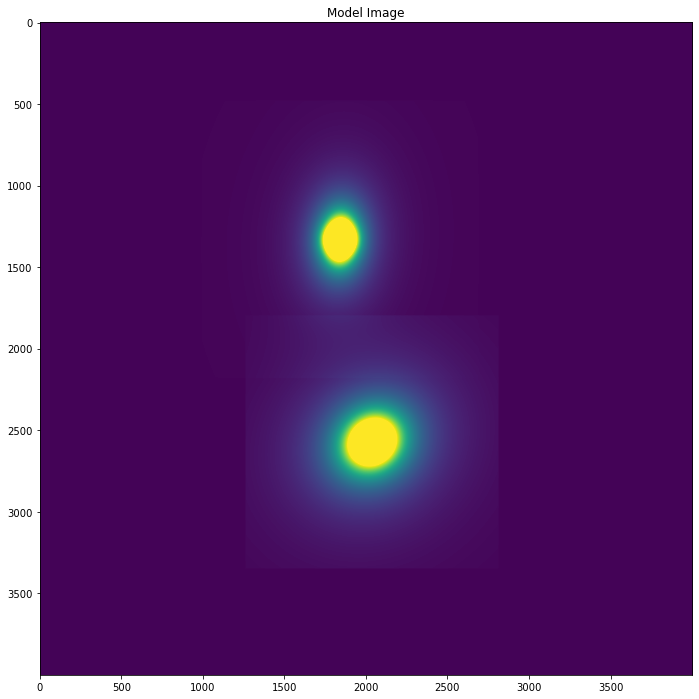

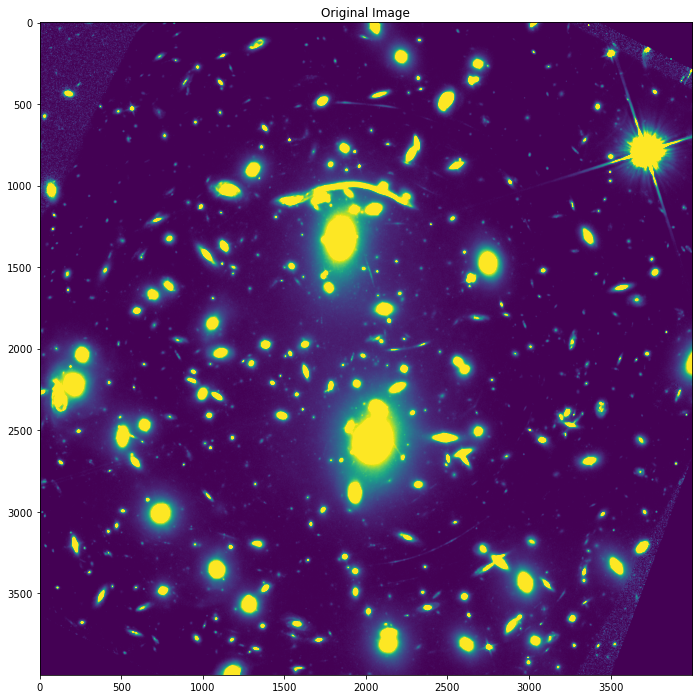

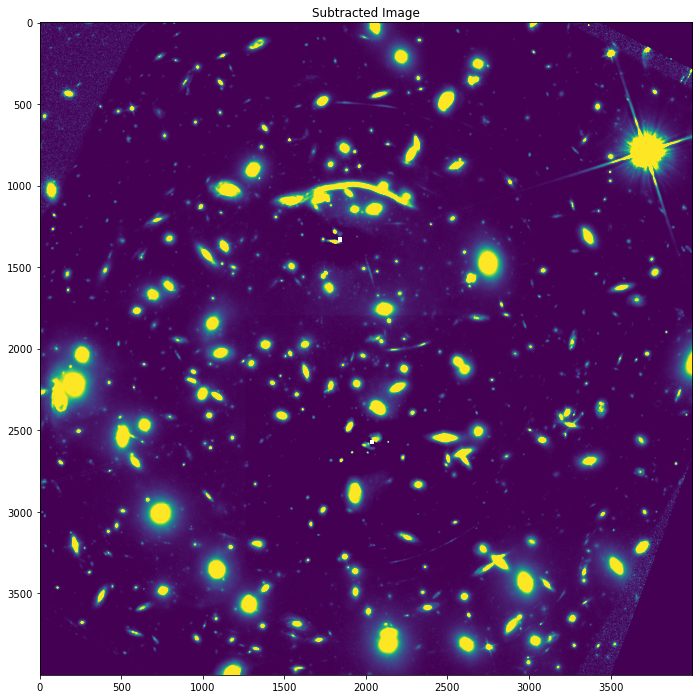

In [24]:
vmin = 0
vmax = mean_noise*100

plt.imshow(image_zero_0 + mean_noise, vmin=vmin, vmax=vmax)
plt.title("Model Image")
plt.show()

plt.imshow(image, vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.show()

plt.imshow(image_copy_0, vmin=vmin, vmax=vmax)
plt.title("Subtracted Image")
plt.show()

IntProgress(value=0, description='Loading:', max=17)

3 78


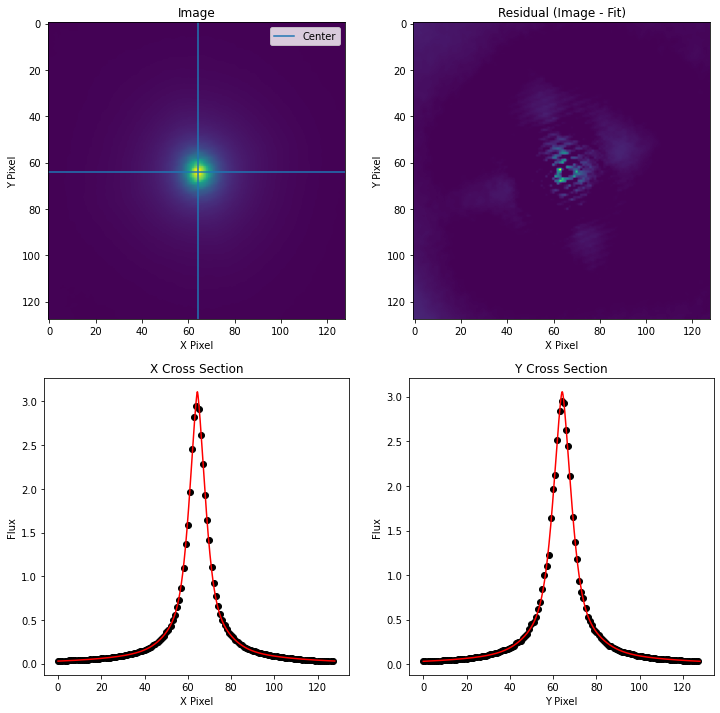

4 47


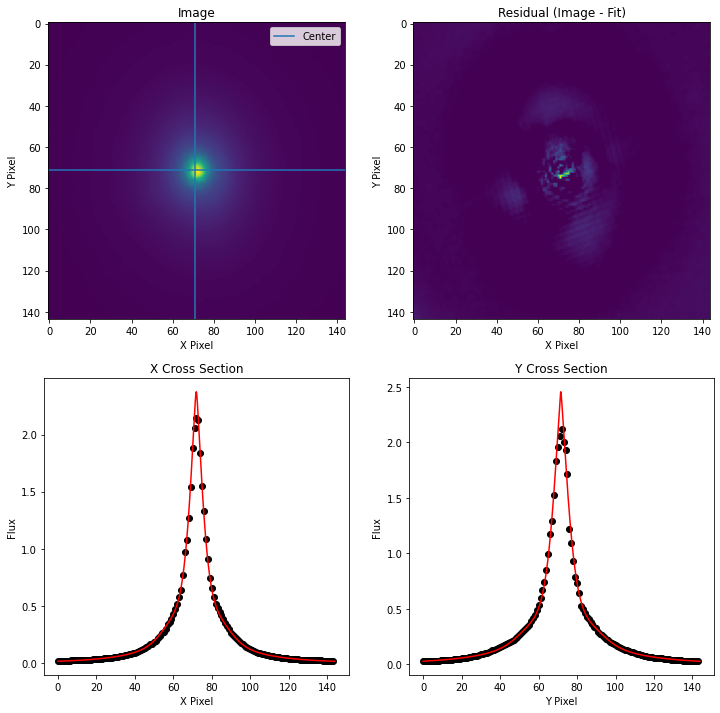

5 186


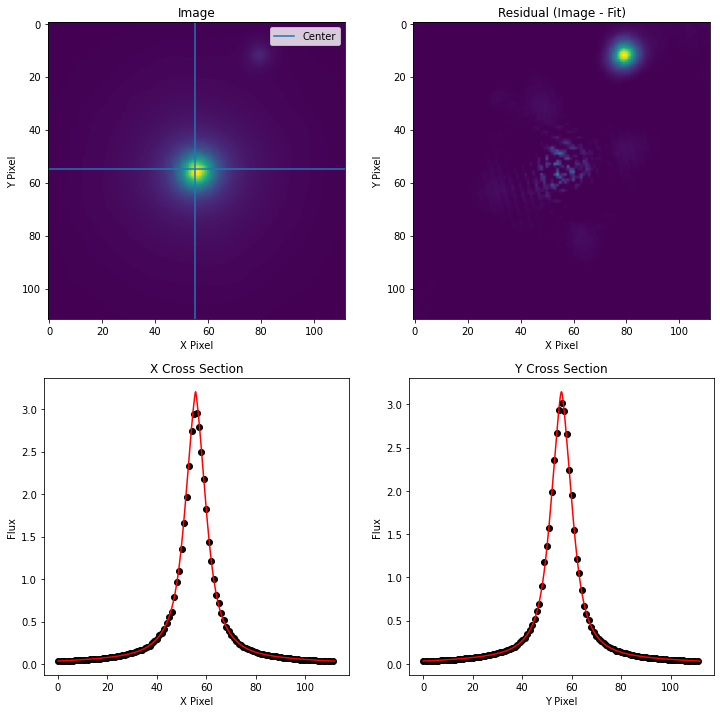

6 13


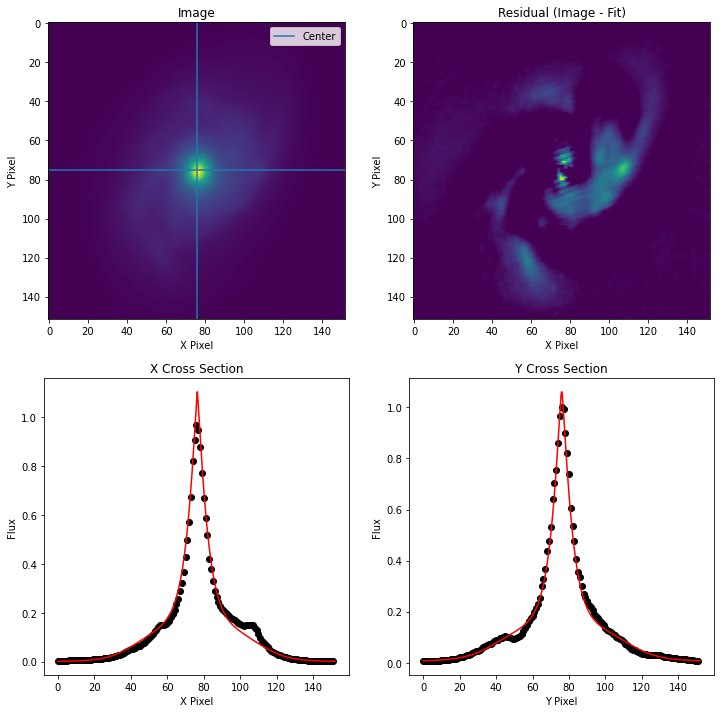

7 89


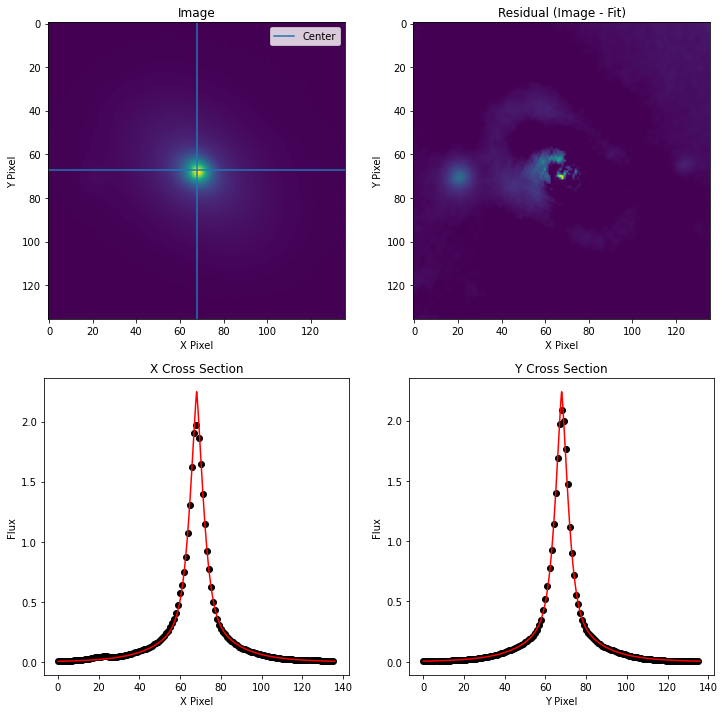

8 135


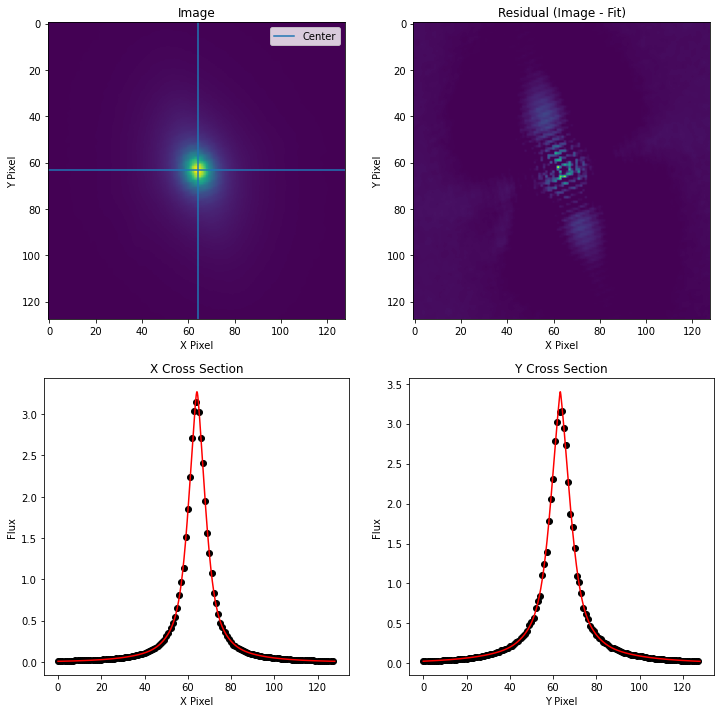

9 190


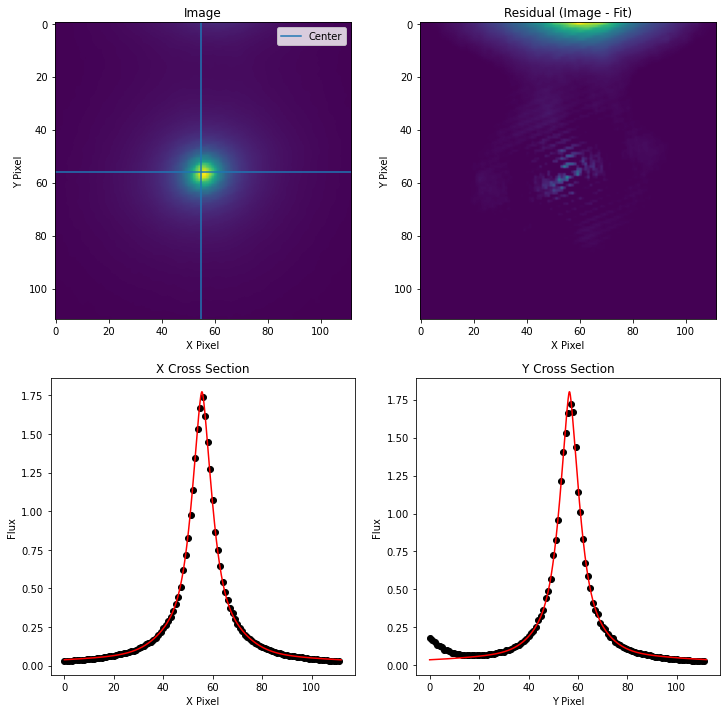

10 131


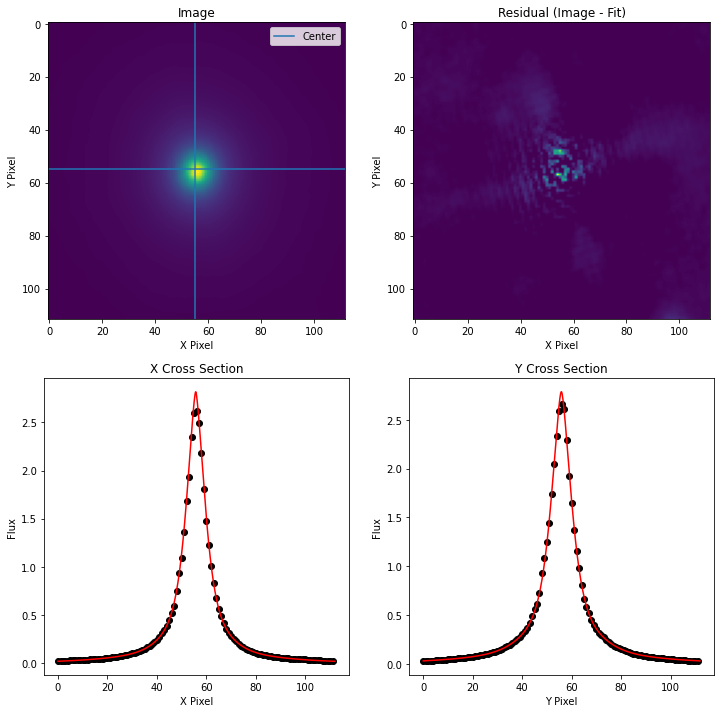

11 99


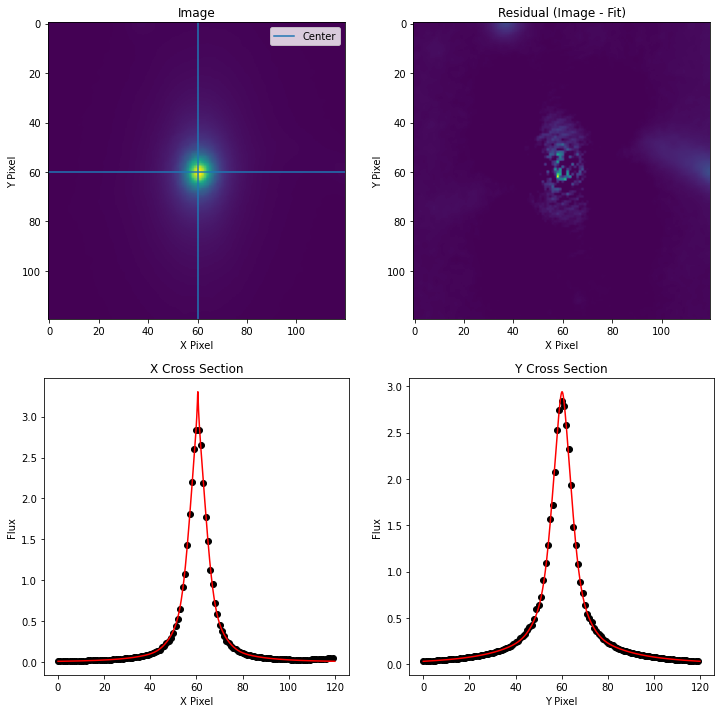

12 101


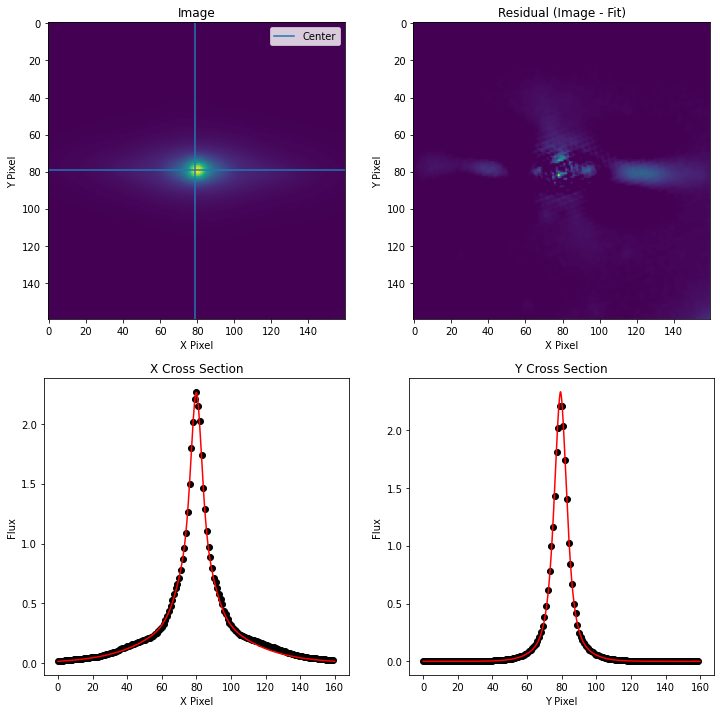

13 188


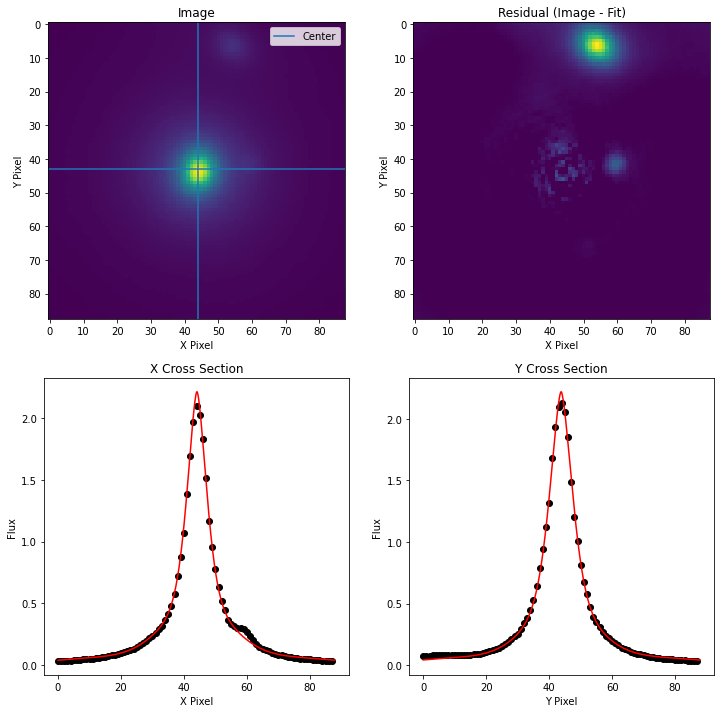

14 130


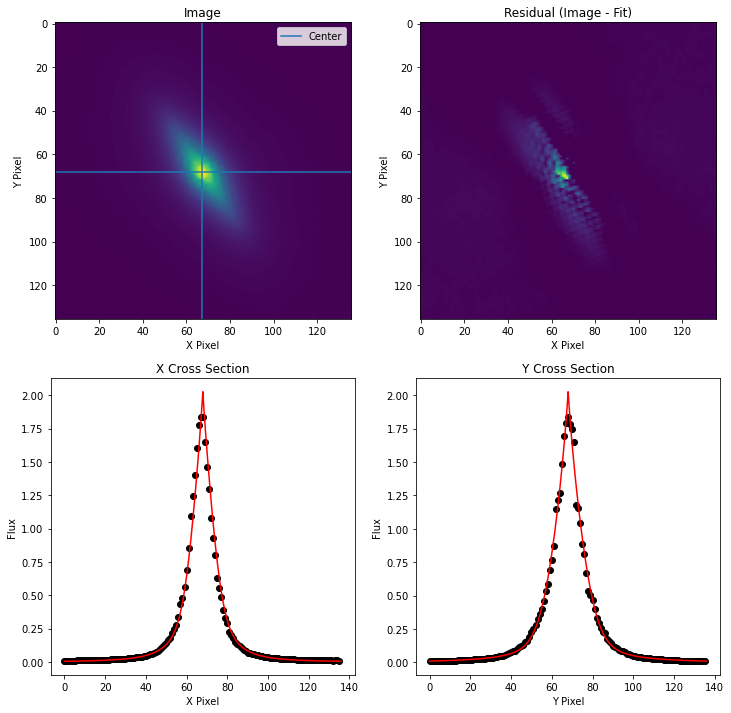

15 35


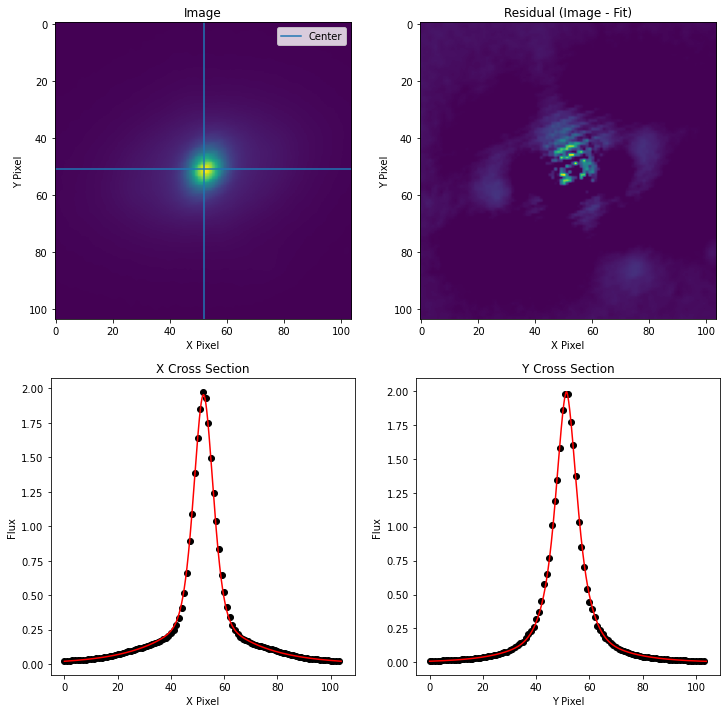

16 27


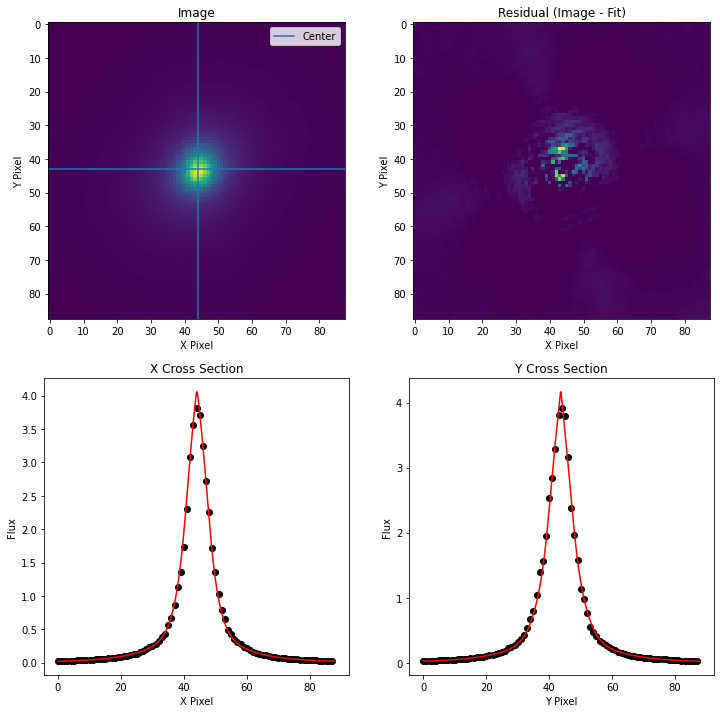

17 189


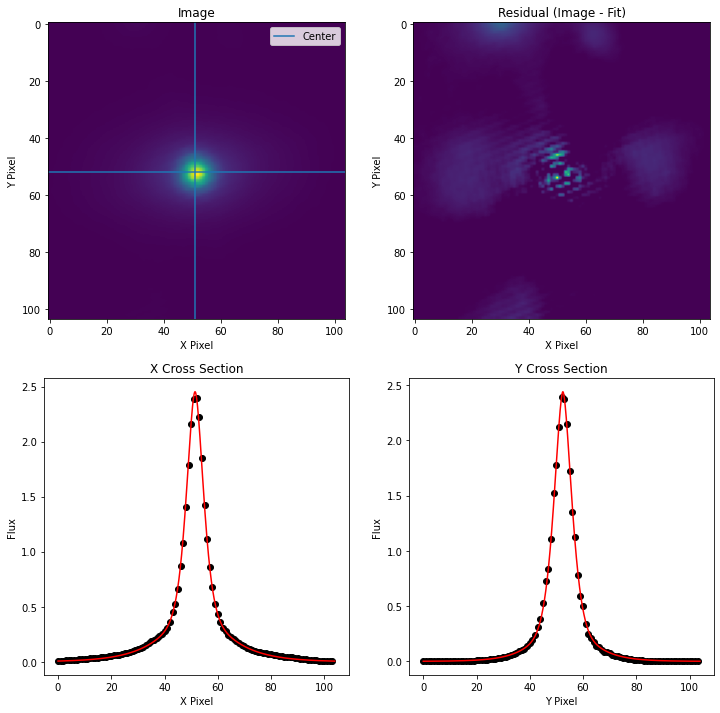

18 60


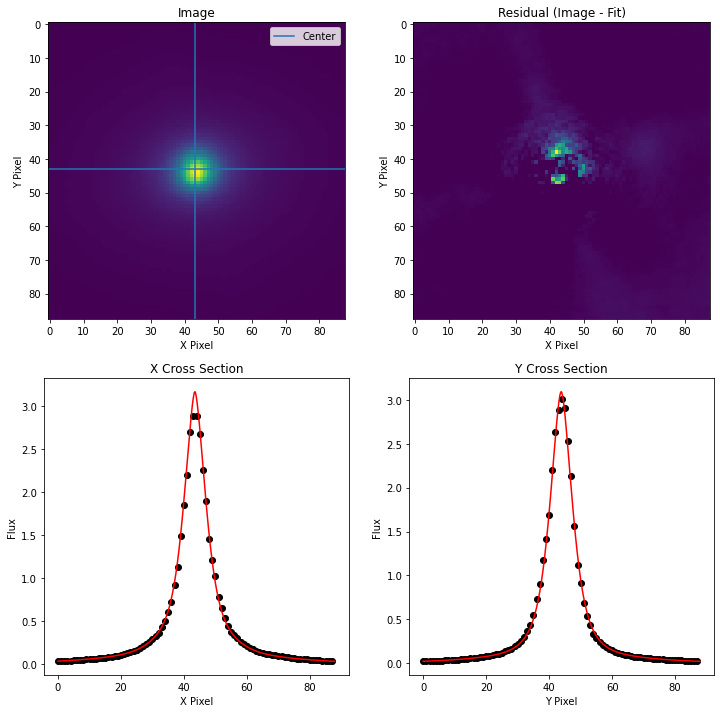

19 67


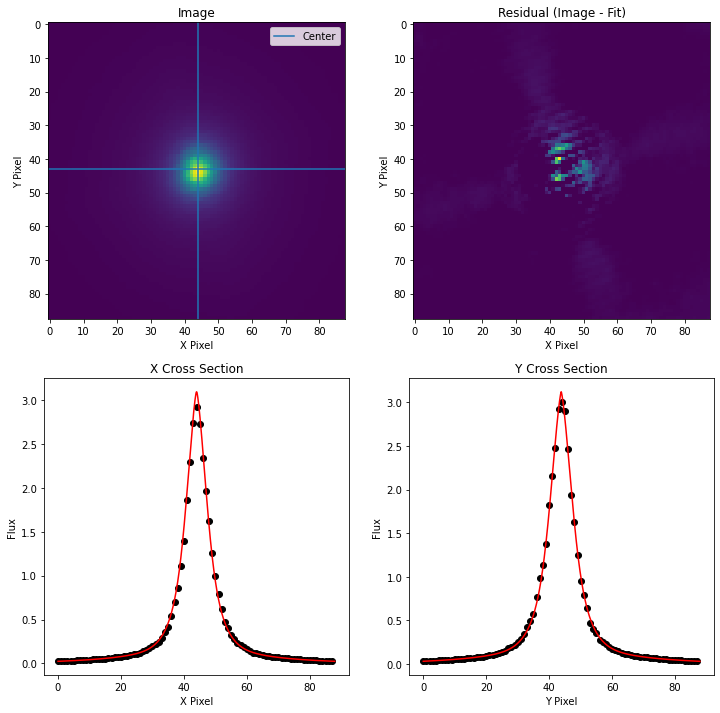

In [25]:
image_copy_1, image_residual_copy_1, image_zero_1, photometric_sums_1 = remove_fitted_sources(
    image_copy_0, image_residual_copy_0, cat, show_progress=True,
    r_inner_mult=1, r_outter_mult=8, index_start=3, index_end=20, n_models=3)

In [26]:
image_copy, image_residual_copy, image_zero =  image_copy_1, image_residual_copy_1, image_zero_1

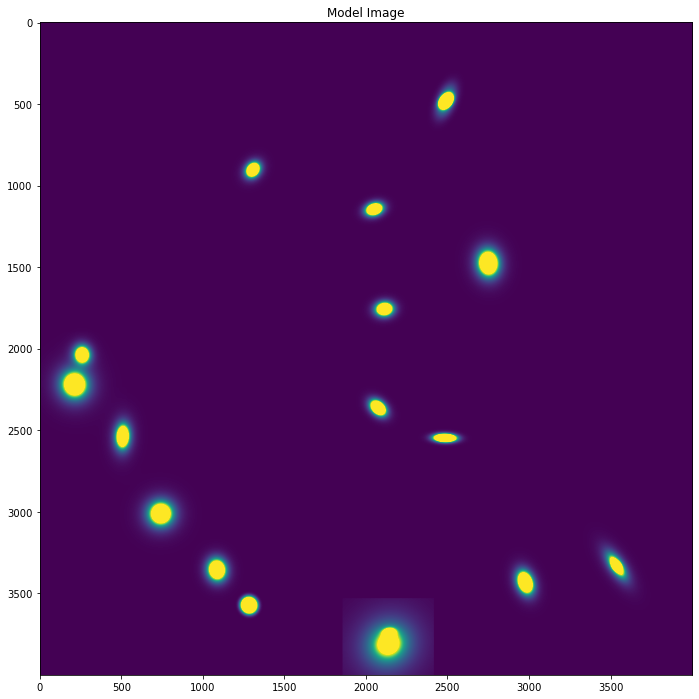

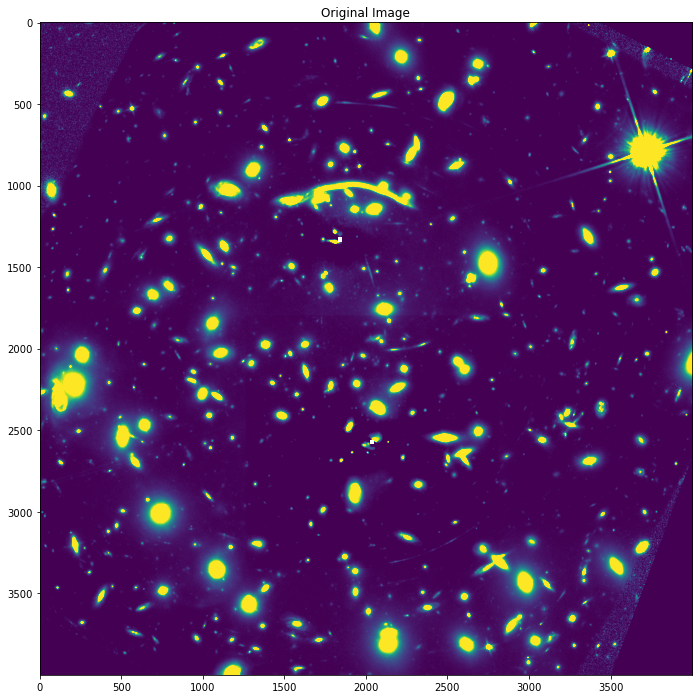

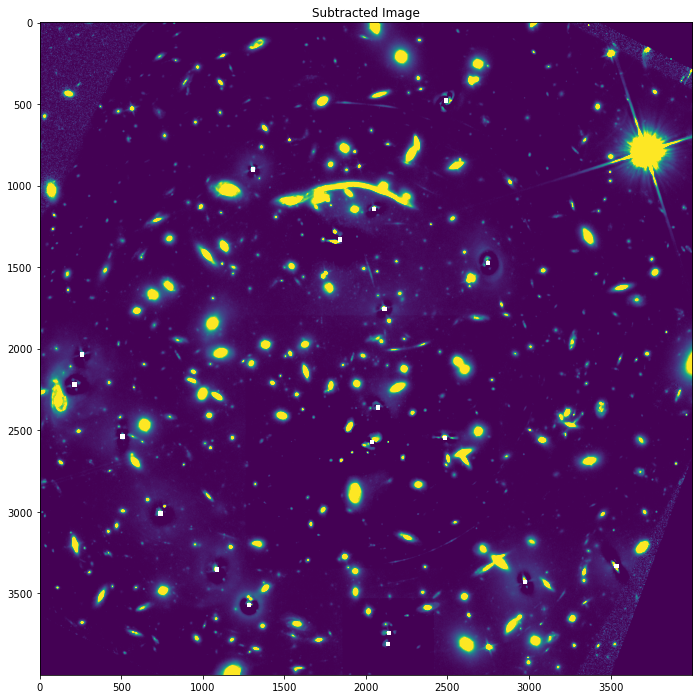

In [27]:
vmin = 0
vmax = mean_noise*100

plt.imshow(image_zero, vmin=vmin, vmax=vmax)
plt.title("Model Image")
plt.show()

plt.imshow(image_copy_0, vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.show()

plt.imshow(image_copy, vmin=vmin, vmax=vmax)
plt.title("Subtracted Image")
plt.show()

# Convolve Subtracted Image

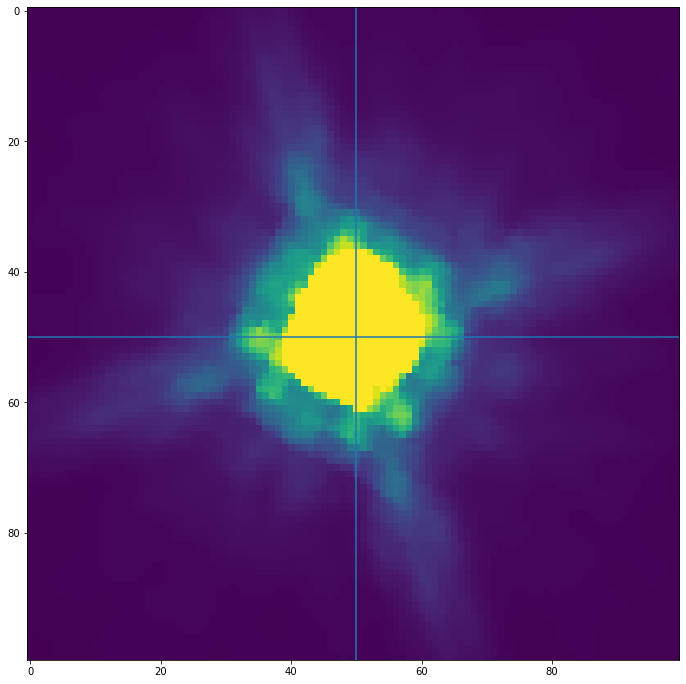

Image Max: 1447.604736328125
Amplitude: 1320.892411902444
Center: (48.91118038868664, 49.62014107453632)
Sigma = (3.5843792317019028, 3.0819133864347483)
Mean FWHM: 8 Pix 
FWHM: (x=8.440568063804275, y=7.25735141942576) Pix 


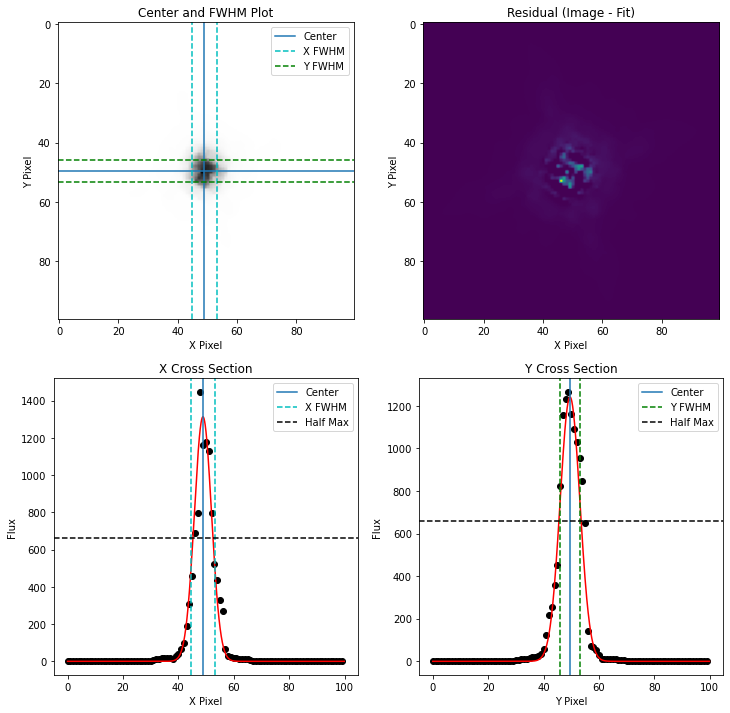

7.848959741615017


In [106]:
# Convolve with PSF sized gaussian.
# First fit gaussian to bright star PSF 

PSF = cutout(data, 5671, 6789, 100, vmin=0)

plt.imshow(PSF, vmin=0, vmax=20)
plt.axhline(PSF.shape[0]//2)
plt.axvline(PSF.shape[0]//2)
plt.show()

star_fwhm = measure_fwhm(PSF).mean()
print(star_fwhm)

In [107]:
kernel = Gaussian2DKernel(x_stddev=3.5, 
                          x_size=31, y_size=31)
kernel.normalize()

image_smoothed = convolve(image_copy, kernel)

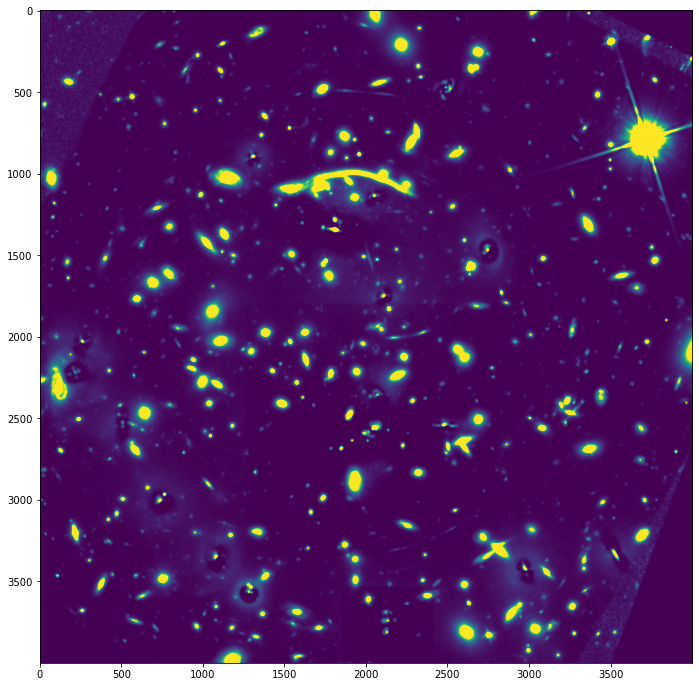

In [108]:
plt.imshow(image_smoothed, vmax=mean_noise*100)

# Do AP on subtracted image 

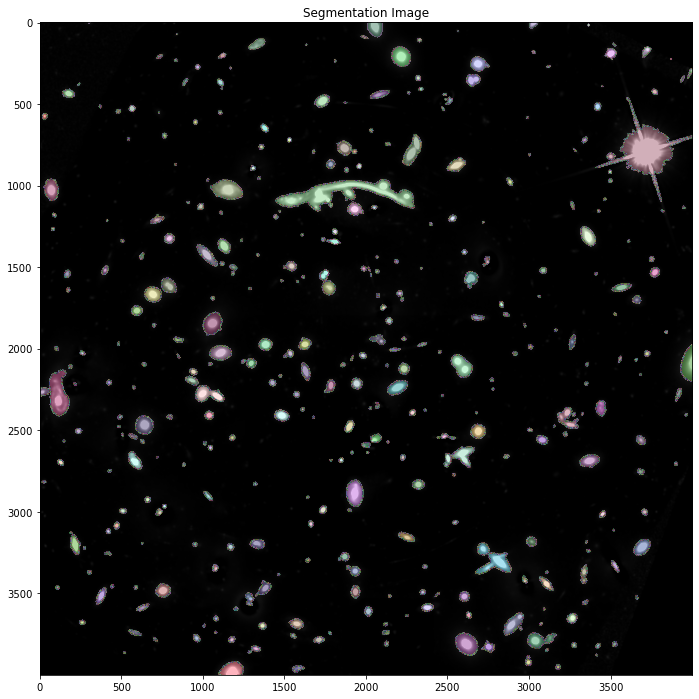

In [109]:
nsigma_smoothed = np.zeros_like(image_smoothed) + image_smoothed.mean()
segm_smoothed = make_segments(image_smoothed, nsigma=nsigma_smoothed, kernel_size=None)
plot_segments(segm_smoothed, image_smoothed, vmin=0, vmax=mean_noise*200)

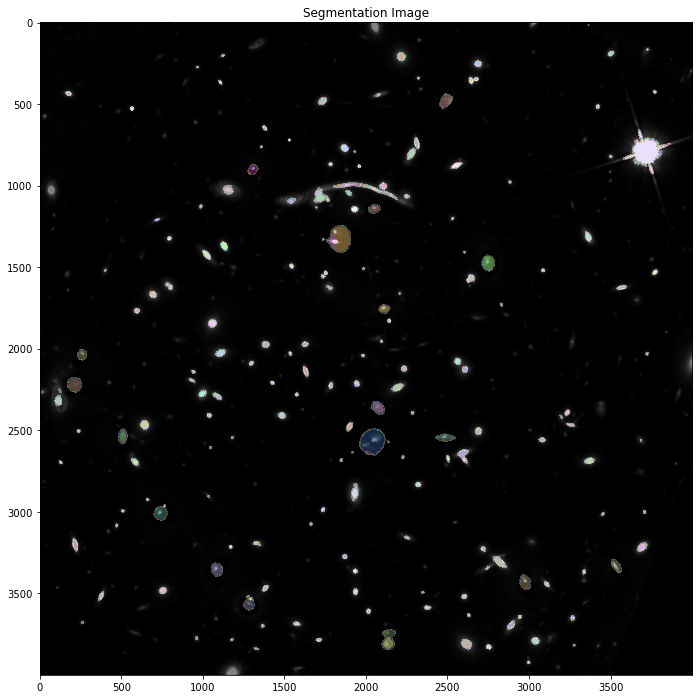

In [110]:
segm_deblend_smoothed = deblend_segments(image_smoothed, segm_smoothed)
plot_segments(segm_deblend, image_smoothed, vmin=0, vmax=mean_noise*300)

In [111]:
segm_deblend_smoothed.remove_border_labels(50)
print(len(segm_deblend_smoothed.segments))
cat_smoothed = source_properties(image_smoothed, segm_deblend_smoothed, wcs=image_wcs)

413


# Zero Points

In [112]:
PHOTFLAM = header['PHOTFLAM']
PHOTFNU  = header['PHOTFNU']
PHOTZPT  = header['PHOTZPT']          
PHOTPLAM = header['PHOTPLAM']          
PHOTBW   = header['PHOTBW']  

In [113]:
STMAG_ZPT = -2.5 * np.log10(PHOTFLAM)- 21.10
STMAG_ZPT

27.693295656576197

In [114]:
ABMAG_ZPT = STMAG_ZPT - 5 * np.log10(PHOTPLAM) + 18.692
ABMAG_ZPT

26.268817868473455

In [115]:
def flux_to_abmag(flux):
    return -2.5*np.log10(flux) + ABMAG_ZPT

## Single Aperture Photometry

In [116]:
r = 25.  # approximate isophotal extent

apertures = []
for obj in cat_smoothed:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    theta = obj.orientation.to(u.rad).value
    apertures.append(CircularAperture(position, r=r))

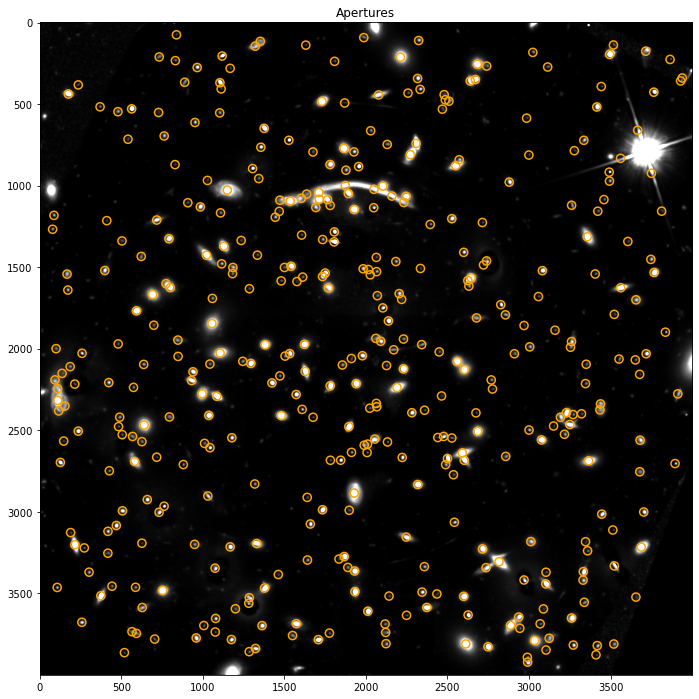

In [117]:
plot_apertures(image_smoothed, apertures, vmin=0, vmax=mean_noise*200, color='orange')

In [118]:
aperture_photometry_results = []
for aperture in apertures:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])

## Save Catalog

In [119]:
single_aperture_photometry_table = cat_smoothed.to_table()
single_aperture_photometry_table['aperture_sum'] = np.array(aperture_photometry_results)
single_aperture_photometry_table['ab_mag'] = flux_to_abmag(np.array(aperture_photometry_results))
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
single_aperture_photometry_table

<QTable length=413>
  id      xcentroid      ...    aperture_sum          ab_mag      
             pix         ...                                      
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    7  838.0367451512531 ...  4.146514705775131 22.713147489838025
    8 1986.7895968591865 ... 17.640883766794417 19.093269994768235
    9 2323.2625149250616 ... 20.663919527236004 18.697844964873354
   10 3517.5735086383356 ... 11.825479400465598 20.093176681418925
   11 1631.1897982778441 ... 3.3680664827160576 23.232970779200883
   12 2212.1743487606477 ... 392.29063509418467 11.338810415638587
   13 3715.5714385469346 ...  53.39267383658958 16.324634012266394
   14  3493.829909971239 ...  546.4646326998768 10.510143894695412
   15 3023.4667835959635 ...  9.680554292699295 20.593519965244482
  ...                ... ...                ...                ...
  422 1284.7163918422227 ... 129.02586753248437 14.118785599055578
  423  1281.583307388231 ...  520.3893977101235 10.632374435764397
  424  2936.781329330257 ...   78.6720557588296 15.355597819923547
  425 2886.7946991045196 ...  260.3919893206289 12.363347501264435
  426  565.3768853378538 ... 23.534684282236075  18.37262971861301
  427  592.3549986579015 ...  25.14596906005572 18.207073849078284
  428 3034.5482219431947 ...  339.8718806133634  11.69739605629931
  429 3123.6136996159603 ... 37.716943833384434   17.1935442883784
  430 2989.6494970343656 ...  20.36134782440273 18.734721895678263
  431 2991.6303776086943 ...  50.56680490473074 16.460579539820706

# Multi Aperture Photometry

In [120]:
radii = [2**n for n in range(1, 5)]

n = 12
max_pix = 60
radii = [x * int(max_pix/n) for x in range(1, n+1)]

#radii.append(25)
radii.sort()

annulus_min = radii[-1] 
annulus_max = radii[-1] * 2 

radii, annulus_min, annulus_max

([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60], 60, 120)

In [121]:
table = cat_smoothed.to_table()['area']
order_all = table.argsort()
order_all = list(order_all)
order = order_all[1:150]
len(order)

149

In [122]:
positions = []
apertures = []
for idx in order:
    obj = cat_smoothed[idx]
    # cut = obj.segment.make_cutout(image, masked_array=True)
    cut_size = 10
    cut = cutout(image_smoothed, 
                    int(np.round(obj.xcentroid.value)), 
                    int(np.round(obj.ycentroid.value)),
                    cut_size)
    
    cy, cx = np.unravel_index(cut.argmax(), cut.shape)
    
    x = int(np.round(obj.xcentroid.value)) + cx - cut_size//2
    y = int(np.round(obj.ycentroid.value)) + cy - cut_size//2
    
    position = np.transpose((x, y))
    positions.append(tuple(position))

apertures = [CircularAperture(positions, r=r) for r in radii]
apertures.append(CircularAnnulus(positions, r_in=annulus_min, r_out=annulus_max))

annulus_aperture = apertures[-1]
annulus_area = annulus_aperture.area

In [123]:
# plot_apertures(image_smoothed, apertures, vmin=0, vmax=mean_noise*100, color='r')

In [124]:
phot_table = aperture_photometry(image_smoothed, apertures)

In [128]:
annulus_masks = annulus_aperture.to_mask(method='center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(image_smoothed)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)

phot_table['annulus_median'] = bkg_median

for i, aperture in enumerate(apertures[:-1]):
    phot_table["aperture_bkg_{}".format(i)] = bkg_median * aperture.area
    bkgsub = phot_table["aperture_sum_{}".format(i)] - phot_table["aperture_bkg_{}".format(i)]
    phot_table["aperture_sum_{}_bkgsub".format(i)] = bkgsub
    
phot_table.sort("aperture_sum_1_bkgsub", reverse=True)
#phot_table

In [129]:
# annulus_bkg_mean = phot_table.columns[-1] / annulus_area
# for i, aperture in enumerate(apertures[:-1]):
#     bkgsub = phot_table["aperture_sum_{}".format(i)] - (annulus_bkg_mean * aperture.area)
#     phot_table["aperture_sum_{}_bkgsub".format(i)] = np.clip(bkgsub, 0, np.inf)
    
# #phot_table.sort("aperture_sum_1_bkgsub")
# phot_table

In [130]:
def slider(x):
    cutout_size = radii[-1]*4
    
    
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    target_bkg = phot_table[x][phot_table.colnames[-1]]/annulus_area
    
    
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(target, vmin=vmin, vmax=vmax)
    ax[0,0].set_title("Target".format(vmax))
    
    ax[0,1].imshow(np.clip(target-target_bkg, 0, target.max()), vmin=vmin, vmax=vmax)
    ax[0,1].set_title("Target [CircularAnnulus Subtracted]")
    
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    for r in radii:
        CircularAperture(position, r=r).plot(ax[0,0], color='w')
        CircularAperture(position, r=r).plot(ax[0,1], color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,0], color='r')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(ax[0,1], color='r')
    
    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, label="Raw")
    
    y_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    ax[1,0].plot(radii, y_values, linestyle='--', label="Bkg Subtracted")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, label="Raw") 
    
    y_values = []
    phot_values = [phot_table["aperture_sum_{}_bkgsub".format(i)][x] for i in range(len(radii))]
    for i in range(len(phot_values)):
        if i == 0:
            y_values.append(phot_values[i])
            continue
        y_values.append(phot_values[i] - phot_values[i-1])    
    ax[1,1].plot(radii, y_values, linestyle='--', label="Bkg Subtracted") 
    
    ax[1,1].set_title("Photometic Density")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Sum")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    cutout_size = radii[-1] * 2
    target = cutout(image_smoothed, 
                    int(round(phot_table[x][1].value)), 
                    int(round(phot_table[x][2].value)),
                    cutout_size)
    
    position = [np.transpose((cutout_size//2, cutout_size//2))]
    
    plt.imshow(target)
    for r in radii:
        CircularAperture(position, r=r).plot(plt.gca(), color='w')
    CircularAnnulus(position, r_in=radii[-1], r_out=radii[-1]*2).plot(plt.gca(), color='r')


    plt.show()

vmin = 0
vmax = mean_noise*0.5
#widgets.interact_manual(slider, x=widgets.IntSlider(min=0, max=len(phot_table)-1));
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(phot_table)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=148), Output()), _dom_classes=('widget-inte…

In [382]:
len([(phot_table["aperture_sum_{}".format(i)]) for i in range(len(radii))])

10

In [44]:
r = 25.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    ellip = obj.semiminor_axis_sigma.value / obj.semimajor_axis_sigma.value 
    a = r 
    b = (1 - ellip)*r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

## Save to Table

In [47]:
table = cat.to_table()
table['aperture_sum'] = np.array(aperture_photometry_results)
table.sort('aperture_sum', reverse=True)

In [48]:
table

<QTable length=441>
  id      xcentroid      ...         gini            aperture_sum   
             pix         ...                                        
int64      float64       ...       float64             float64      
----- ------------------ ... -------------------- ------------------
  105 1807.7498235594676 ...   0.5497458380100056 1323.5194369840003
  193 215.91330051850713 ...  0.10021636159097286 1060.9098782457343
  374 2739.6328027993445 ...   0.2946231860194561 1046.7286728760037
  287 2970.6061679474433 ...  0.35186751617249457 1034.1402286583777
  281 3524.4521162740302 ...   0.3489765573676772  910.1470100448505
   67 1303.5072499693838 ...    0.401673508046884  815.0026879999289
  429  2048.225420702691 ...   0.2949773568782795  787.4974605396835
  219  505.8921534078758 ...  0.05412191310175176  705.7163428952223
  218 2478.4111322648223 ...  0.30869073328279084  703.1967410323974
  ...                ... ...                  ...                ...
  226   147.688995500672 ...  0.04591801714815769 1.8843022880676012
  276 274.00439361198625 ...  0.11994569423921818 1.5903360121157173
  125 1613.1139399781598 ...  0.15844373124041372 1.5628695677026698
   49  2985.979430388065 ... 0.055844891267630085 1.4014759335784028
  107 3606.9611588851994 ...  0.08084670351359115  1.230048164931706
  133 2070.9308642615665 ...   0.1622402197750686  1.054364474328946
  228 1011.2232320587624 ...  0.13996567605283136 0.8525142153722411
  130 1286.4514672680414 ...   0.0968710661032836 0.7861145410053829
  150 3160.3338682140966 ...  0.09221504278941556 0.5063779392897749
  118 2335.1887258650854 ...  0.05748570830660313 0.4700334342018775

In [49]:
table.write(output_path, format="ascii.csv", overwrite=True)

# Compare Processed Image vs Raw Data 

In [94]:
r = 3.  # approximate isophotal extent

apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

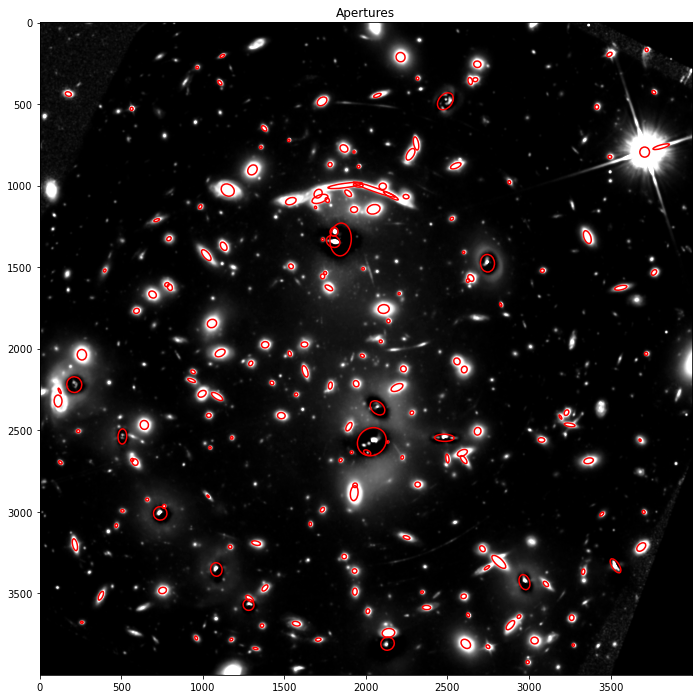

In [101]:
plot_apertures(image_smoothed, apertures, vmax=mean_noise*100, color='red')

In [95]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image_smoothed, aperture)['aperture_sum'][0])
    
a2 = np.array(aperture_photometry_results)

In [96]:
aperture_photometry_results = []
for aperture in apertures[len(order):]:
    aperture_photometry_results.append(aperture_photometry(image, aperture)['aperture_sum'][0])
    
a1 = np.array(aperture_photometry_results)

In [53]:
np.round(100*(a1-a2)/a1, 2).astype(int)

array([                   0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                   89,
                          0, -9223372036854775808, -9223372036854775808,
                          0,                    0,                    0,
                          0,                   92,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                    0,                    0,
                          0,                   15,                    0,
                          0,                    0,                    2,
                          0,                    0,                    0,
       -9223372036854775808,                    0, 

In [54]:
xh, yh = np.histogram(np.round(100*(a1-a2)/a1))
plt.bar(yh[:-1], xh)

ValueError: autodetected range of [nan, nan] is not finite

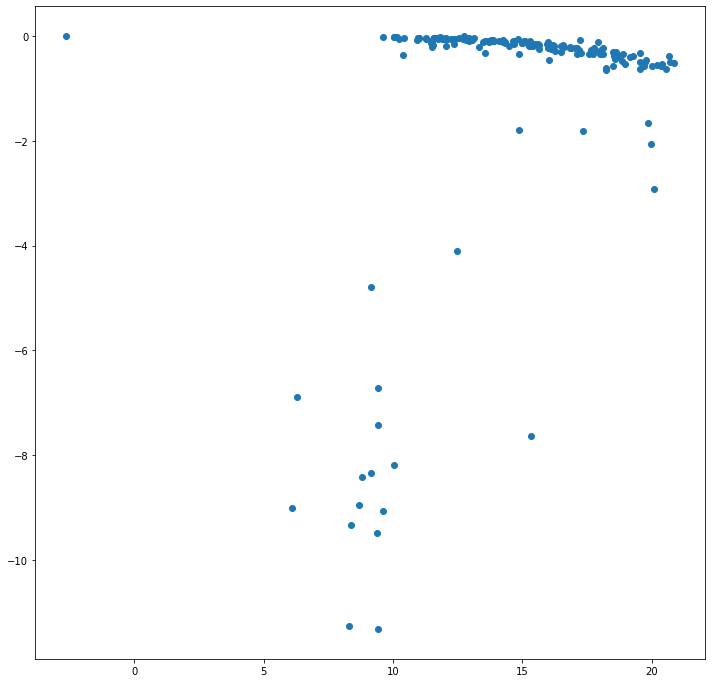

In [108]:
plt.scatter(
    flux_to_abmag(a1),
    flux_to_abmag(a1) - flux_to_abmag(a2)
)

# Scrap

In [165]:
>>> from astropy.stats import SigmaClip
>>> from photutils import Background2D, MedianBackground
>>> sigma_clip = SigmaClip(sigma=3.)
>>> bkg_estimator = MedianBackground()
>>> bkg = Background2D(image, (50, 50), filter_size=(3, 3),
...                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

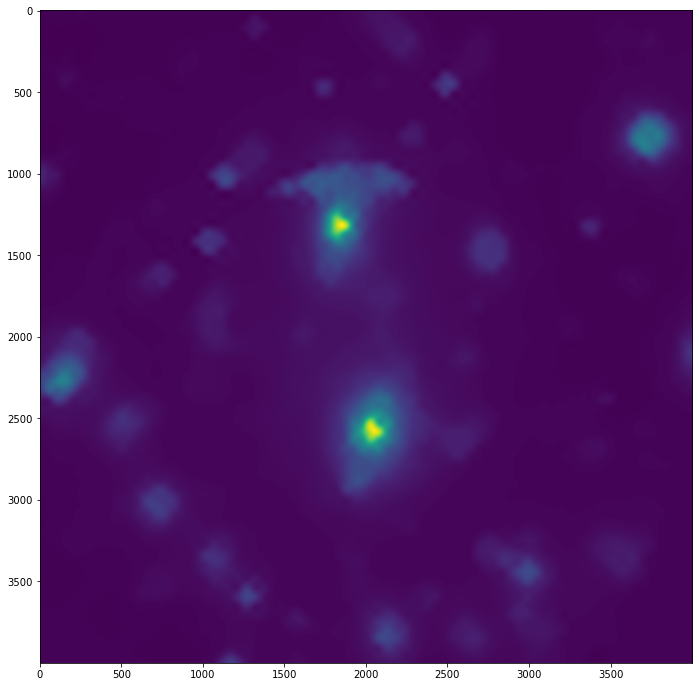

In [38]:
plt.imshow(bkg.background)

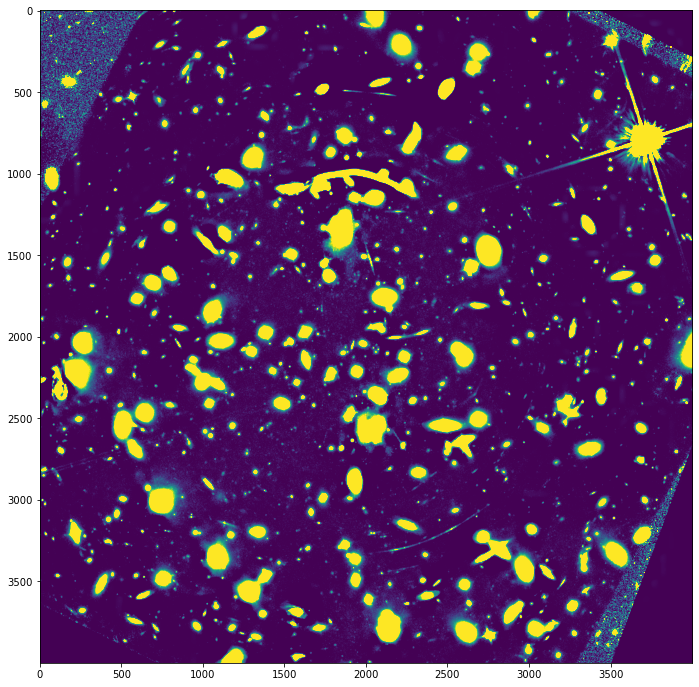

In [180]:
plt.imshow(np.clip(image-bkg.background,0, 1e20), vmin=0, vmax=mean_noise*20)

In [172]:
bkg_sub = 

In [173]:
bkg_sub.mean()

0.0

In [175]:
image.mean()

0.012618022

In [176]:
bkg.data.mean()

0.012618022

In [177]:
np.allclose(image, bkg.data)

True

In [181]:
image = image-bkg.background